<a href="https://colab.research.google.com/github/Yunxin-Deng/Transfer-Matrix-Calculation-For-Multivalent-Interactions/blob/main/Kinetic_Simulation_of_Multivalent_Interactions_Gillespie_DualDomains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kinetic-Simulation-of-Multivalent-Interactions-Gillespie

In [ ]:
# @title Initialization
# Initialization

import numpy as np
import random as rd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.integrate as spi
import zipfile
import os

#refolding rate calculation
def int_WLC(f, L):
    def WLC(x):
        return (x + 1 / (4 * (1 - x) ** 2) - 0.25) * 4.1 / 0.8 - F
    F = f
    sol = fsolve(WLC, 0.8)
    x_unit = sol[0]
    def force(x):
        return (x + 1 / (4 * (1 - x) ** 2) - 0.25) * 4.1 / 0.8
    result, error = spi.quad(force, 0, x_unit)
    result_int = L * result- f * x_unit * L
    return result_int/4.1

def get_kr(ku, mu, f, L):
    kr = ku/(np.exp(-mu-int_WLC(f, L)))
    return kr

# function to calculate array dP and region based on the current state
def set_dp_gillespie(para):
    s, fa, kd0, ku0, mu, d, u, L, F = para.copy()
    dP = [[0,0]] * len(s)
    kd = kd0*np.exp(d*F/4.1)
    ku = ku0*np.exp(u*F/4.1)
    kr = get_kr(ku, mu, F, L)
    kr0 = get_kr(ku, mu, 0, L)
    for i in range(len(s)):
        if s[i]==-1:
            if all(s[:i+1]!=1):
                dP[i] = [kr,0]
            else:
                dP[i] = [kr0,0]
        elif s[i]==1:
            dP[i] = [0,kd]
        elif s[i]==0:
            if any(s==1):
                if all(s[:i+1]!=1):
                    dP[i] = [ku, fa]
                else:
                    dP[i] = [ku0, fa]
            else:
                dP[i] = [ku, fa]
    dP_flat = [item for sublist in dP for item in sublist]

    return dP_flat

def lifetime_cal_gillespie(cycle_for_avg, t, para):
    lifetimes = np.zeros(cycle_for_avg)
    for num in range(cycle_for_avg):
        c_para = para.copy()
        s = para[0].copy()
        n_a = [sum(s==1)]
        n_u = [sum(s==-1)]
        t_start = 0
        t_stop = t
        tau = 0
        tau_array = [0]
        tau_sum = 0
        while tau_sum<=t:
            c_para[0] = s.copy()
            bound_before = any(s==1)
            randnum_1 = rd.random()
            a_array = set_dp_gillespie(c_para)
            a_sum = sum(a_array)
            tau = np.log(1/randnum_1)/a_sum
            tau_sum += tau
            tau_array.append(tau_sum)
            randnum_2 = rd.random()
            for j in range(len(a_array)):
                if randnum_2*a_sum-sum(a_array[:j+1])<=0:
                    site = int(j//2)
                    tran = (j+1)%2
                    if tran==0:
                        s[site] = 1 - s[site]
                    elif tran==1:
                        s[site] = -1 - s[site]
                    break
            n_a.append(sum(s==1))
            n_u.append(sum(s==-1))
            bound_now = any(s==1)
            if ((not bound_before) and bound_now):
                t_start = tau_sum
            if (bound_before and (not bound_now)):
                t_stop = tau_sum
                break
        if t_stop-t_start>t:
            lifetimes[num] = t
        else:
            lifetimes[num] = t_stop - t_start
        print("cycle: %.d, "%(num+1), "lifetime: %f s"%lifetimes[num])

    return lifetimes, n_a, n_u, tau_array

In [ ]:
# @title Set the values below before running the simulation.
# Set values

n = 3 # @param {type:"integer"}

fa = 10 # @param {type:"number"}
kd0 = 1 # @param {type:"number"} #dissociation rate of one domain-site, unit: s^-1
d = 0.07 # @param {type:"number"} #dissociation transition distance, unit: nm

ku0 = 0.05 # @param {type:"number"} #unfolding rate of one domain-site at F=0, unit: s^-1
u = 0.2 # @param {type:"number"} #unfolding transition distance, unit: nm
mu = 10 # @param {type:"number"} #folding free energy, unit: k_BT
L =  30 # @param {type:"number"} #contour length of a protein site, unit: nm

t = 5000 # @param {type:"number"} #the maximum running time, unit: s
cycle_for_avg = 50 # @param {type:"integer"}
start_force = 0 # @param {type:"integer"}
end_force = 80 # @param {type:"integer"}
force_interval = 5 # @param {type:"integer"}

F =  np.arange(start_force, end_force, force_interval) #force range (start_force, end_force, interval)

In [ ]:
# @title Run the below simulation process
#Simulation process

s_i = np.ones(n)
para_force = [s_i, fa, kd0, ku0, mu, d, u, L, F[0]]
lifetimes_array = [np.array([cycle for cycle in range(1,cycle_for_avg+1)])]
domain_as_unf = []
for i in range(len(F)):
    para_force[-1] = F[i].copy()
    para_force[0] = s_i.copy()
    print("multivalency: %.d, "%n, "force: %.d pN"%F[i])
    lifetimes, n_a, n_u, tau_array= lifetime_cal_gillespie(cycle_for_avg, t, para_force)
    lifetimes_array.append(lifetimes)
    domain_as_unf.append([tau_array, n_a, n_u])
    print("lifetimes: %.6f s"%np.mean(lifetimes),"\nstd_lifetime: %.6f s\n"%np.std(lifetimes))

multivalency: 3,  force: 0 pN
cycle: 1,  lifetime: 34.549534 s
cycle: 2,  lifetime: 10.347906 s
cycle: 3,  lifetime: 6.738322 s
cycle: 4,  lifetime: 3.175115 s
cycle: 5,  lifetime: 23.044726 s
cycle: 6,  lifetime: 72.526556 s
cycle: 7,  lifetime: 19.866296 s
cycle: 8,  lifetime: 64.151098 s
cycle: 9,  lifetime: 38.081127 s
cycle: 10,  lifetime: 45.001109 s
cycle: 11,  lifetime: 30.549479 s
cycle: 12,  lifetime: 5.518886 s
cycle: 13,  lifetime: 4.816473 s
cycle: 14,  lifetime: 61.603281 s
cycle: 15,  lifetime: 47.149057 s
cycle: 16,  lifetime: 7.928632 s
cycle: 17,  lifetime: 128.488413 s
cycle: 18,  lifetime: 20.822037 s
cycle: 19,  lifetime: 117.483622 s
cycle: 20,  lifetime: 49.913021 s
cycle: 21,  lifetime: 52.628184 s
cycle: 22,  lifetime: 158.938505 s
cycle: 23,  lifetime: 38.471756 s
cycle: 24,  lifetime: 107.261822 s
cycle: 25,  lifetime: 150.122757 s
cycle: 26,  lifetime: 28.162181 s
cycle: 27,  lifetime: 88.043485 s
cycle: 28,  lifetime: 23.833378 s
cycle: 29,  lifetime: 93.69

In [ ]:
# @title Download results -- the bound and unfolded number of domains
#Download results -- lifetimes


file_name = "test_lifetimes" # @param {type:"string"}


head_txt = 'cycle_num\t' + '\t'.join([str(int(force)) for force in F])
file_name += '.txt'
np.savetxt(file_name, np.transpose(lifetimes_array), header=head_txt, comments='')

In [ ]:
# @title Download results -- the bound and unfolded number of domains
#Download results -- the bound and unfolded number of domains

zip_file = "test_zip" # @param {type:"string"}


zip_file += ".zip"
with zipfile.ZipFile(zip_file, 'w') as zip_object:
    for i in range(len(F)):
        txt_name = 'states_%.d pN.txt'%F[i]
        head_txt = 'Time\t' + 'Bound num\t' + 'Unfolded num'
        np.savetxt(txt_name, np.transpose(domain_as_unf[i]), header=head_txt, comments='')
        zip_object.write(txt_name)
        os.remove(txt_name)

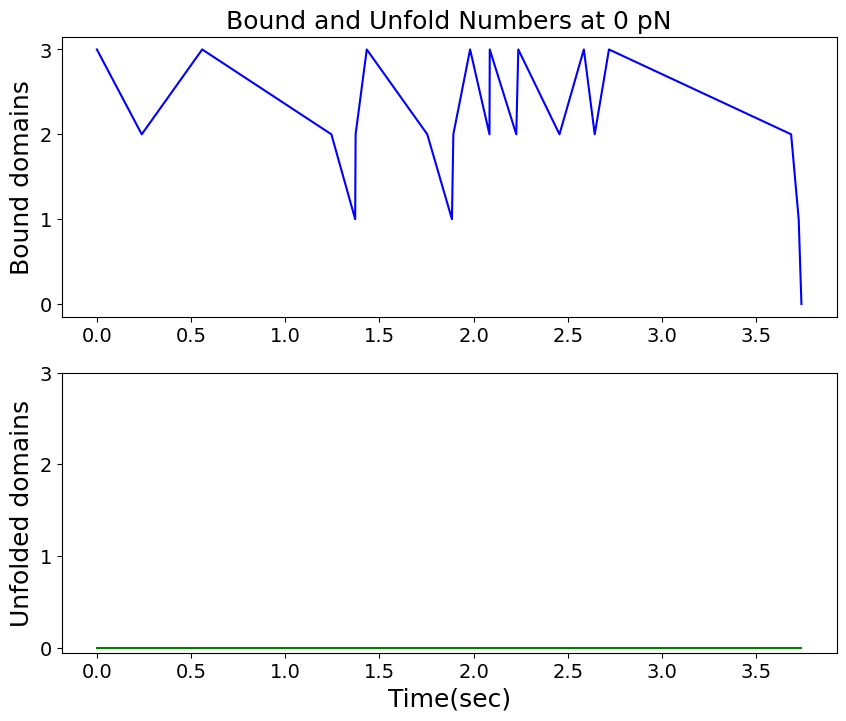

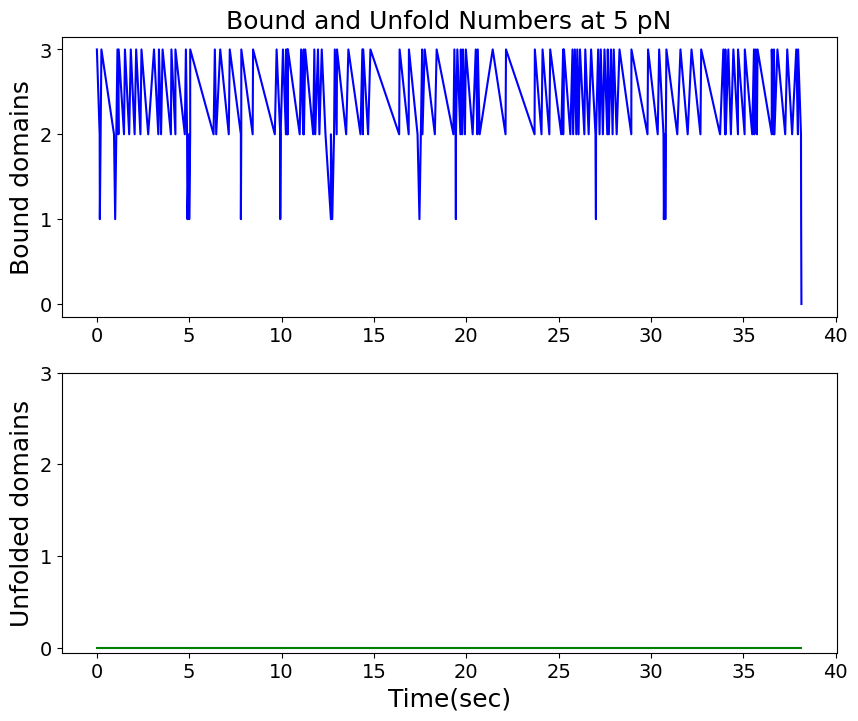

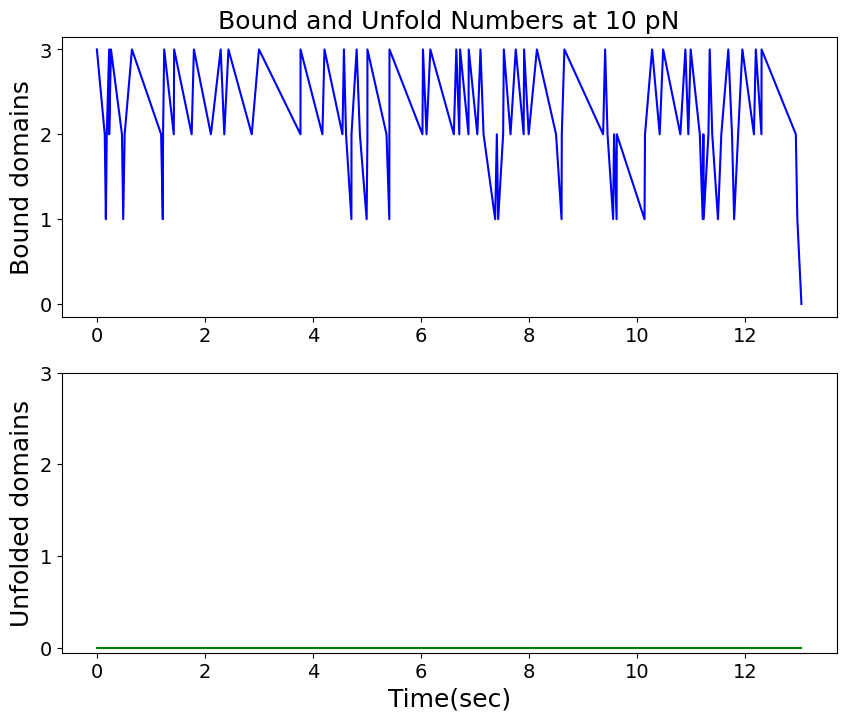

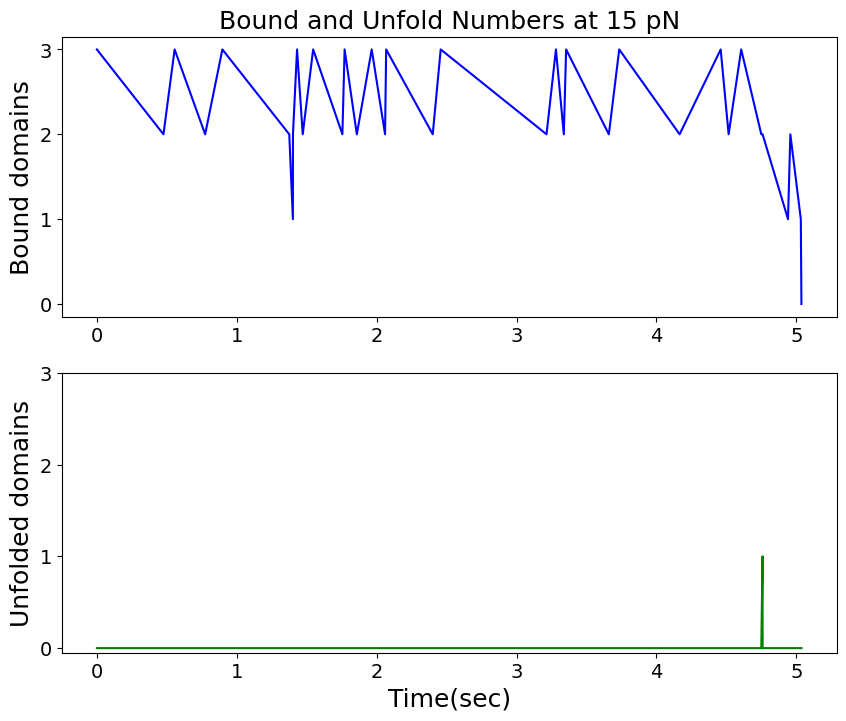

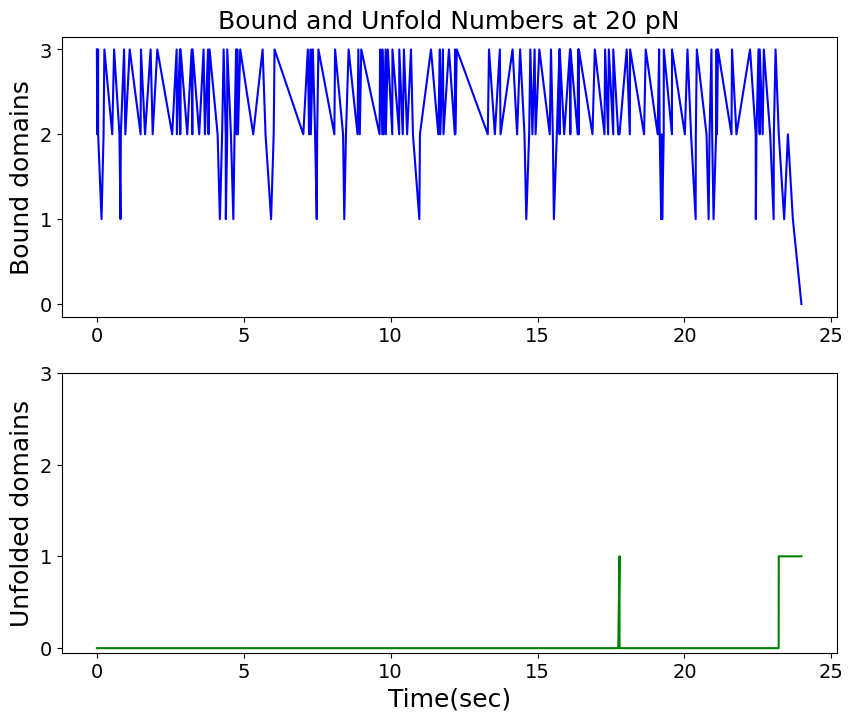

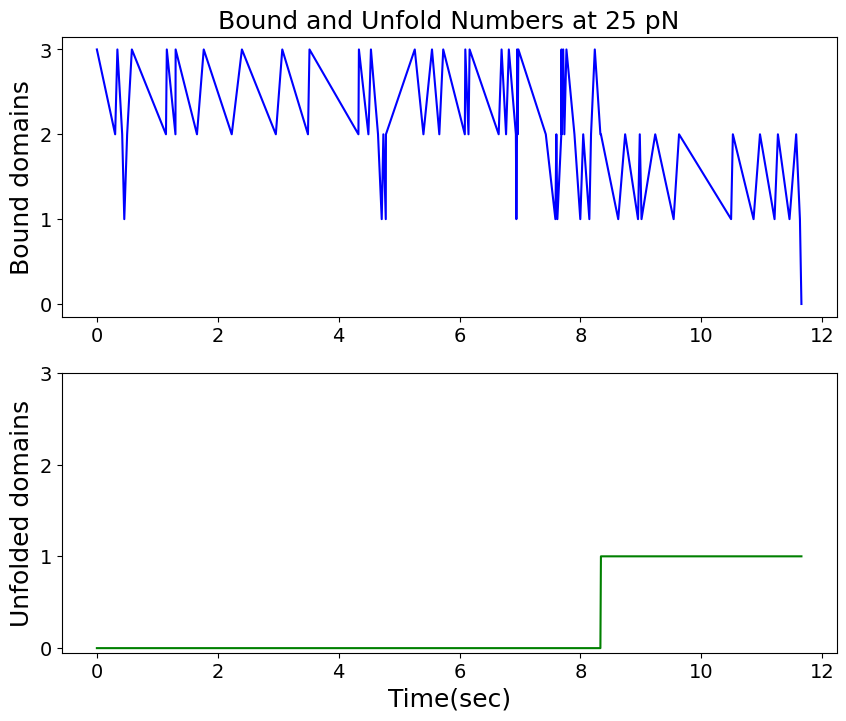

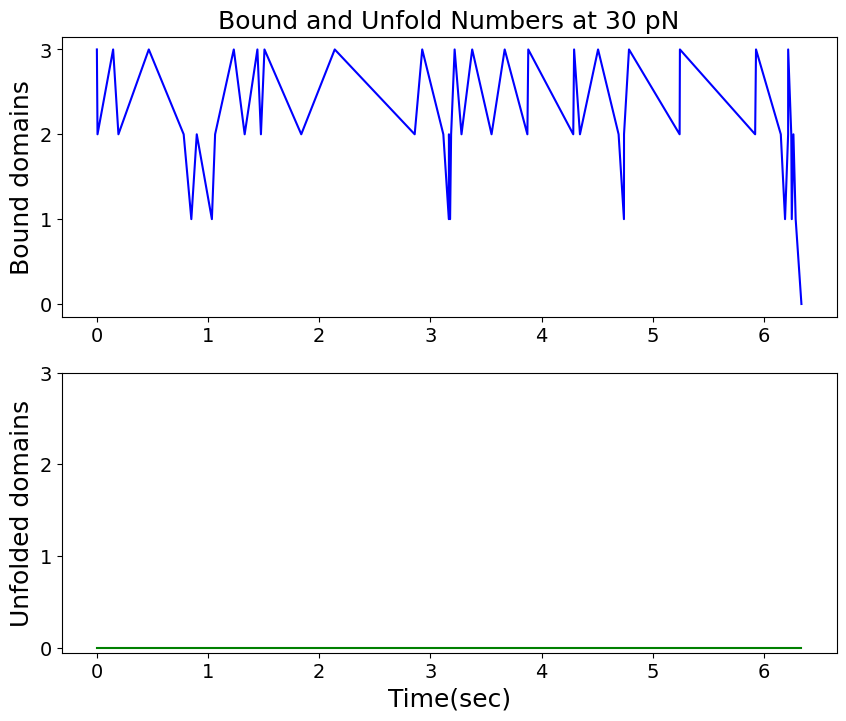

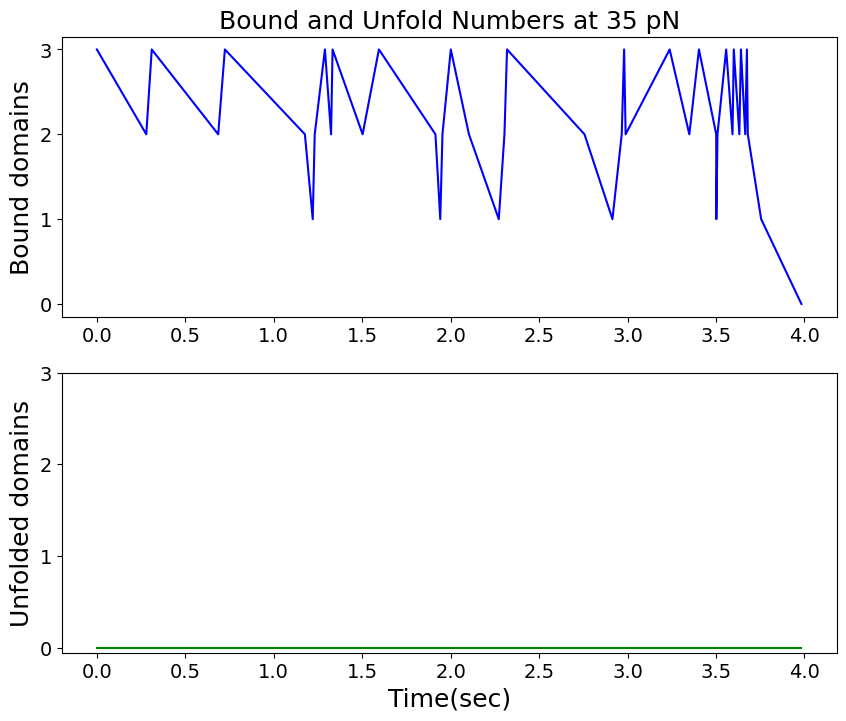

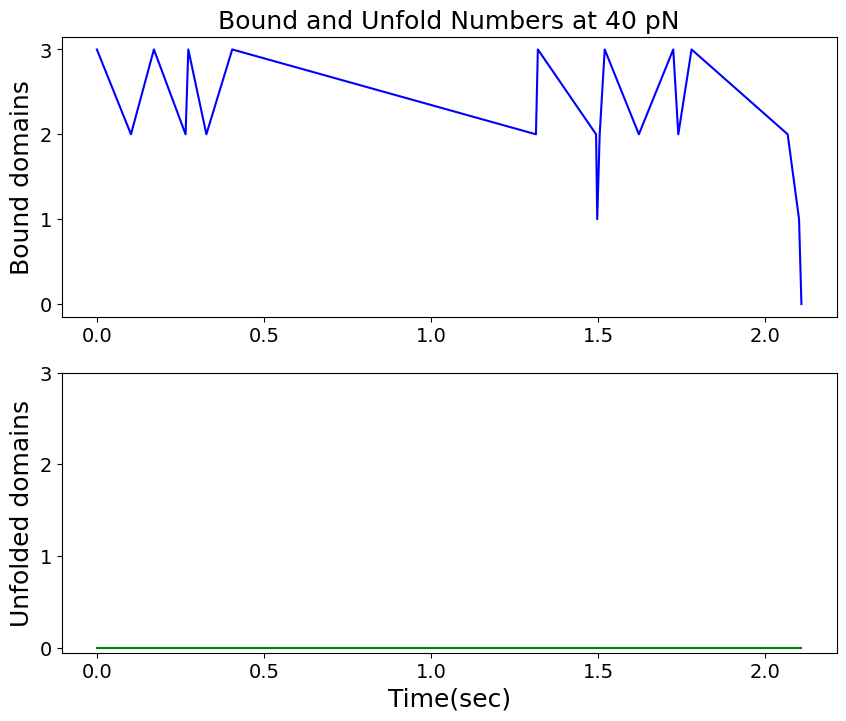

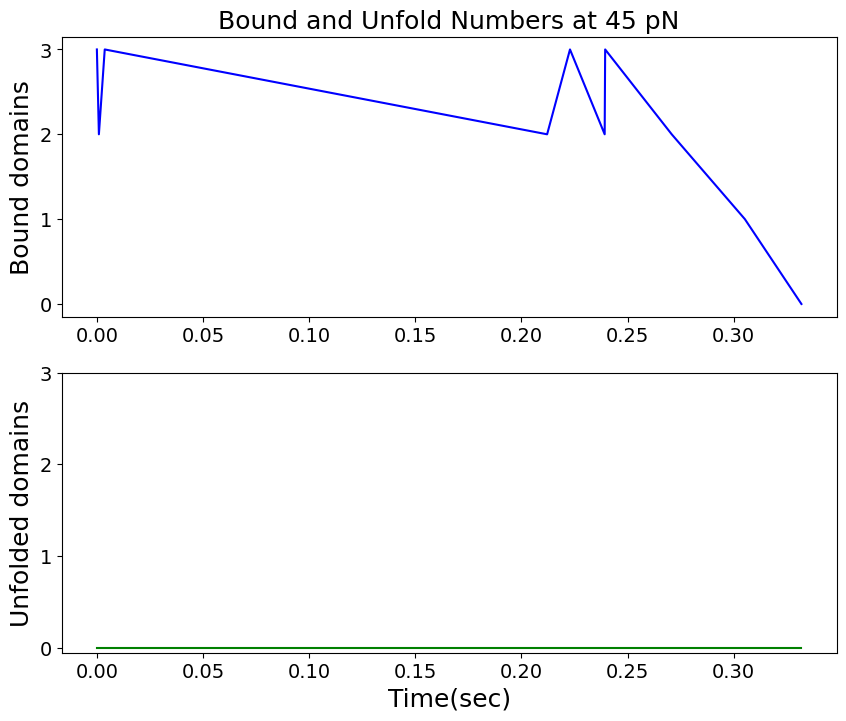

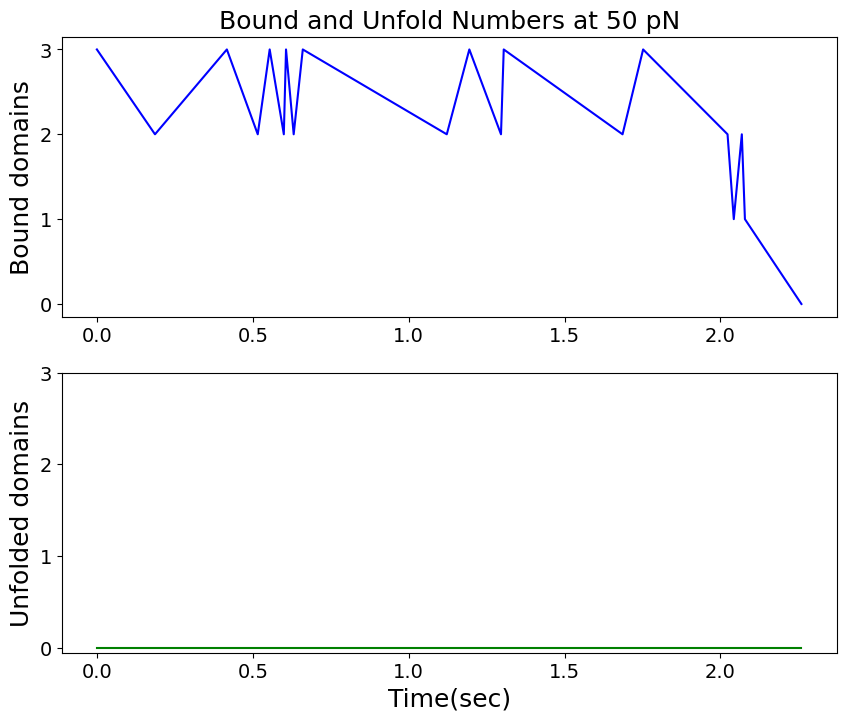

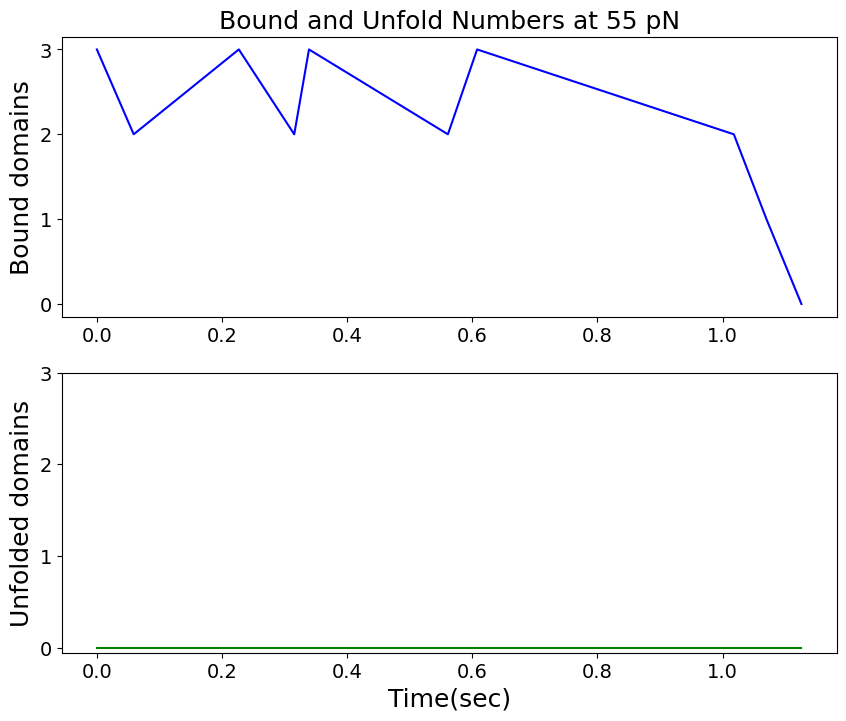

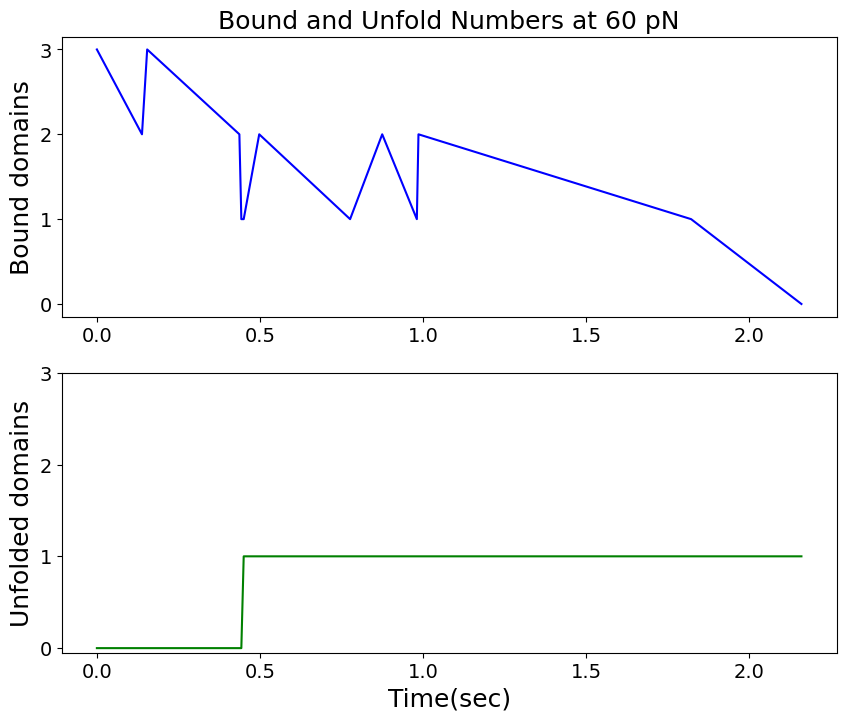

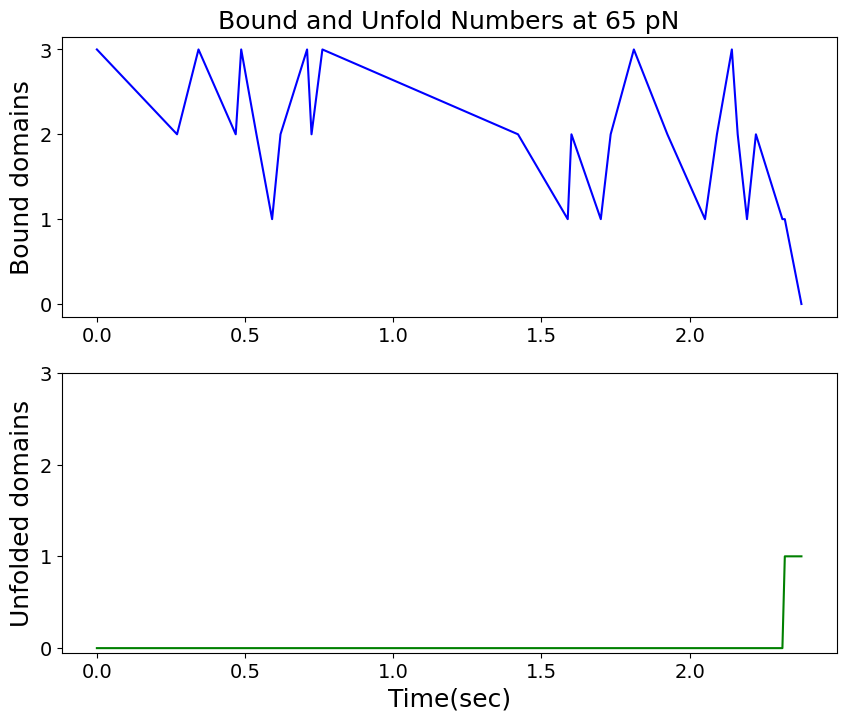

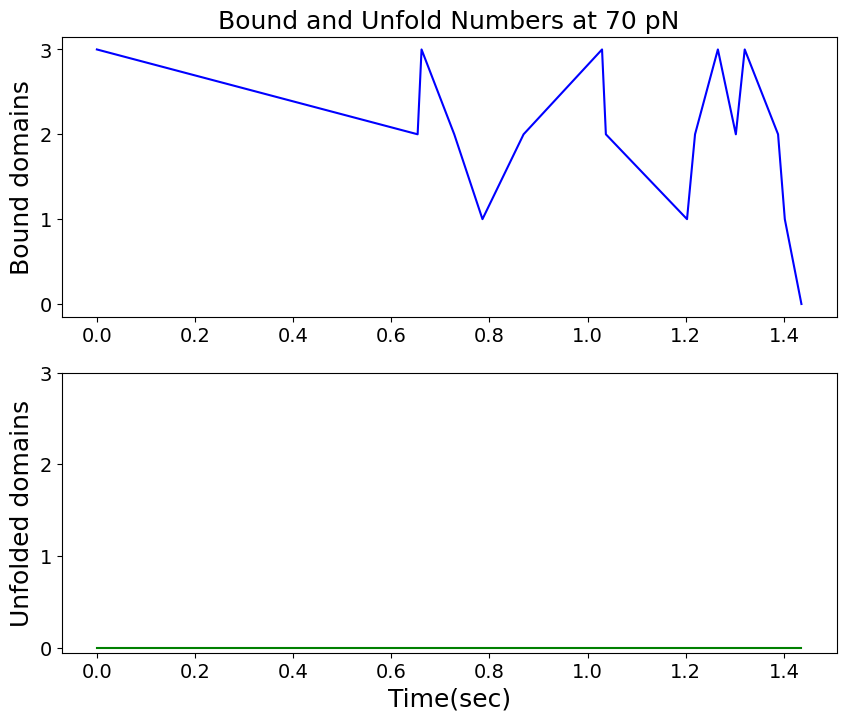

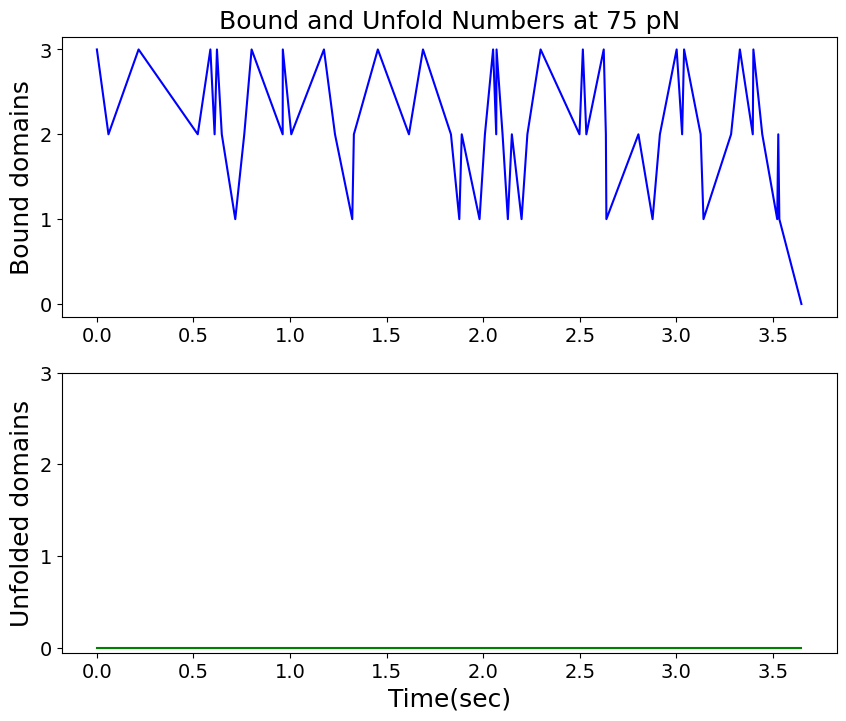

In [ ]:
# @title (Optional) Make plot of the bound and unfolded number of domains
#(Optional) Make plot of the bound and unfolded number of domains

for i in range(len(F)):
    fig = plt.figure(figsize=[10,8])
    plt.subplot(2,1,1)
    plt.title('Bound and Unfold Numbers at %.d pN'%F[i], size=18)
    plt.plot(domain_as_unf[i][0],domain_as_unf[i][1], color='b')
    plt.ylabel('Bound domains',  size=18)
    plt.yticks(np.arange(0, n+0.5, step=1))
    plt.tick_params(labelsize=14)

    plt.subplot(2,1,2)
    plt.plot(domain_as_unf[i][0], domain_as_unf[i][2], color='g')
    plt.xlabel('Time(sec)',  size=18)
    plt.ylabel('Unfolded domains',  size=18)
    plt.yticks(np.arange(0, n+0.5, step=1))
    plt.tick_params(labelsize=14)
    plt.show()